# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
import csv
from PIL import Image
import numpy as np
import os
from tensorflow.keras.models import load_model

tf.enable_v2_behavior()

split_data = False   ## Use it only once to split data into train/test using annotation file
BATCH_SIZE = 32
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 25
NUM_CLASSES = 2
run_type = 'colab' # 'local' or 'colab'
train_teacher = False

In [2]:
if run_type == 'local':
    data_path = 'G:/My Drive/Colab Notebooks/MHIST/'
elif run_type == 'colab':
    # Giving Access to Google Drive for loading data
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    data_path = '/content/drive/My Drive/Colab Notebooks/MHIST/'

Mounted at /content/drive


# Data loading

In [3]:
def train_test_split(output_dir):
  import shutil

  file_name = 'annotations.csv'
  ## Create directories for output train/test
  os.makedirs(output_dir, exist_ok=True)
  os.makedirs(output_dir + 'train/HP/', exist_ok=True)
  os.makedirs(output_dir + 'train/SSA/', exist_ok=True)
  os.makedirs(output_dir + 'test/HP/', exist_ok=True)
  os.makedirs(output_dir + 'test/SSA/', exist_ok=True)

  with open(data_path + file_name) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')

    for line, row in enumerate(csv_reader):
        if line > 0:
          print('[INFO] Image number:' + str(line) + ' - Image Name: ' + row[0])
          src = data_path + 'images_unzip/' + row[0]
          dst = output_dir + row[3] + '/' + row[1] + '/' + row[0]
          shutil.copy(src, dst)

if split_data:
  # Just do it once for data building
  train_test_split(data_path + 'images_split/')

builder = tfds.ImageFolder(data_path + 'images_split/', shape = (224, 224, 3))
print(builder.info)

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_dir='/root/tensorflow_datasets/image_folder/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(224, 224, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=977, num_shards=1>,
        'train': <SplitInfo num_examples=2175, num_shards=1>,
    },
    citation="""""",
)


In [4]:
# Load train and test splits.
def preprocess(x):
  image, label = x['image'], x['label']
  image = tf.image.convert_image_dtype(image, tf.float32)
  subclass_labels = tf.one_hot(label, builder.info.features['label'].num_classes)


  return image, subclass_labels


mhist_train = builder.as_dataset(split='train', shuffle_files=False).cache()
mhist_train = mhist_train.map(preprocess)
mhist_train = mhist_train.shuffle(builder.info.splits['train'].num_examples)
mhist_train = mhist_train.batch(BATCH_SIZE, drop_remainder=True)

mhist_test = builder.as_dataset(split='test').cache()
mhist_test = mhist_test.map(preprocess).batch(BATCH_SIZE)

In [5]:
IMG_SHAPE = (224, 224, 3)
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
], name = "data_augmentation")

# Model creation

In [6]:
#@test {"output": "ignore"}
## Teacher model
# load trained base model
resnet_base = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                  weights="imagenet")
resnet_base.trainable = False
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = resnet_base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
logits = tf.keras.layers.Dense(NUM_CLASSES)(x)
teacher_model = tf.keras.Model(inputs, logits)

##############################################################################

## Student Model
# load trained base model
def build_student_model():
  mobilenet_base = tf.keras.applications.MobileNetV2(include_top=False,
    input_shape=IMG_SHAPE, weights="imagenet")
  mobilenet_layers_num = len(mobilenet_base.layers)
  mobilenet_base.trainable = False

  inputs = tf.keras.Input(shape=IMG_SHAPE)
  x = data_augmentation(inputs)
  x = mobilenet_base(x, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.1)(x)
  logits = tf.keras.layers.Dense(NUM_CLASSES)(x)

  # Build teacher model with inputs and outputs
  return tf.keras.Model(inputs, logits), mobilenet_base


In [7]:
teacher_model.summary()
num_layers_teacher = len(resnet_base.layers)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0     

In [8]:
student_model, student_base = build_student_model()
student_model.summary()
num_student_layer = len(student_base.layers)

9406464/9406464 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 512)               655872 

# Teacher loss function

In [9]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = teacher_model(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits( \
          labels, subclass_logits))


  return cross_entropy_loss_value

# Student loss function

In [10]:
#@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits/temperature, axis = -1)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = student_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = teacher_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits,
                student_subclass_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits))

  return ALPHA*distillation_loss_value + (1 - ALPHA)*cross_entropy_loss_value

# Train and Evaluation

In [8]:
from sklearn.metrics import f1_score

def compute_F1_score(true_binary, pred_binary):
  """Compute F1 score between true labels and prediction.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  return f1_score(true_binary, pred_binary)

def get_binary_labels_batch(model, images, labels):
  class_logits = model(images, training=False)
  pred_binary = tf.argmax(class_logits, -1).numpy()
  true_binary = tf.argmax(labels, -1).numpy()
  return true_binary, pred_binary

@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn, lr, num_epochs):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

  f1_score_epochs, class_acc_epochs = [], []
  for epoch in range(1, num_epochs + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mhist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    true_binary, pred_binary = [], []
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mhist_test:
      # your code start from here for step 4
      true_bin_batch, pred_bin_batch = get_binary_labels_batch(model, images, labels)
      true_binary.append(true_bin_batch)
      pred_binary.append(pred_bin_batch)

      num_correct_batch, pred_digit, true_digit = compute_num_correct(model, images, labels)
      num_correct += num_correct_batch

    ## Estimate F1 score
    true_binary = np.concatenate(true_binary)
    pred_binary = np.concatenate(pred_binary)
    F1_score = compute_F1_score(true_binary, pred_binary)
    f1_score_epochs.append(F1_score)
    class_acc_epochs.append(num_correct / num_total * 100)
    print("F1 score: {:.2f} - Class accuracy: {:.2f}%".format(F1_score,
                                            num_correct / num_total * 100))
  return f1_score_epochs, class_acc_epochs

# Training models

# Training Teacher Model from Scratch

In [9]:
resnet_base_scratch = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                  weights=None)
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = resnet_base_scratch(x, training = True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
logits = tf.keras.layers.Dense(NUM_CLASSES)(x)
teacher_model_scratch = tf.keras.Model(inputs, logits)



@tf.function
def compute_teacher_loss_scratch(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = teacher_model_scratch(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits( \
          labels, subclass_logits))


  return cross_entropy_loss_value


########### Training Teacher From Scratch ####################
tot_num_epochs = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
print('Training for Teacher Model from scratch')
f1_hist, acc_hist =  train_and_evaluate(teacher_model_scratch, compute_teacher_loss_scratch, 1e-4, tot_num_epochs)
print('Average F1 score and class accuracy for the last five epochs')
print('F1 score = ' + str(np.mean(f1_hist[-5:])))
print('class accuracy = ' + str(np.mean(acc_hist[-5:])))

Training for Teacher Model from scratch
Epoch 1: 

F1 score: 0.21 - Class accuracy: 62.13%
Epoch 2: F1 score: 0.17 - Class accuracy: 64.48%
Epoch 3: F1 score: 0.56 - Class accuracy: 66.84%
Epoch 4: F1 score: 0.32 - Class accuracy: 66.43%
Epoch 5: F1 score: 0.21 - Class accuracy: 65.92%
Epoch 6: F1 score: 0.31 - Class accuracy: 66.73%
Epoch 7: F1 score: 0.53 - Class accuracy: 70.93%
Epoch 8: F1 score: 0.55 - Class accuracy: 67.04%
Epoch 9: F1 score: 0.48 - Class accuracy: 70.21%
Epoch 10: F1 score: 0.53 - Class accuracy: 71.75%
Epoch 11: F1 score: 0.46 - Class accuracy: 70.62%
Epoch 12: F1 score: 0.60 - Class accuracy: 73.69%
Epoch 13: F1 score: 0.51 - Class accuracy: 70.62%
Epoch 14: F1 score: 0.49 - Class accuracy: 71.24%
Epoch 15: F1 score: 0.54 - Class accuracy: 71.55%
Epoch 16: F1 score: 0.55 - Class accuracy: 72.36%
Epoch 17: F1 score: 0.52 - Class accuracy: 69.40%
Epoch 18: F1 score: 0.43 - Class accuracy: 68.68%
Epoch 19: F1 score: 0.49 - Class accuracy: 71.85%
Epoch 20: F1 score: 0.53 - Class accuracy: 70.52%
Epoch 21: F1 score

# Transfer Learning Step for Teacher Model


*   First, train additional feature/classification layers (fix base model)
*   Second, fine tune overall model



In [ ]:
## Check if to train teacher model or load pre-trained one
if train_teacher:
  # Initial training for the teacher model
  print('INITIAL Training for Teacher Model')
  f1_hist, acc_hist =  train_and_evaluate(teacher_model, compute_teacher_loss, 1e-4, INITIAL_EPOCHS)

  ## Fine Tuning Step (make all layers trainable)
  resnet_base.trainable = True
  # Fine tune only top layers (e.g. above 100)
  fine_tune_at = 100
  for layer in resnet_base.layers[:fine_tune_at]:
    layer.trainable = False
  print('FINE TUNING Training for Teacher Model')
  f1_hist, acc_hist = train_and_evaluate(teacher_model, compute_teacher_loss, 0.1*1e-4, FINE_TUNE_EPOCHS)
  if run_type == 'local':
    teacher_model.save('Teacher_Model_Task2.h5')
    np.savez('Teacher_Model_Task2_hist.npz', f1_hist = f1_hist, acc_hist = acc_hist)
  else:
    teacher_model.save('/content/drive/My Drive/Colab Notebooks/Teacher_Model_Task2.h5')
    np.savez('/content/drive/My Drive/Colab Notebooks/Teacher_Model_Task2_hist.npz',
             f1_hist = f1_hist, acc_hist = acc_hist)

  print('Average F1 score and class accuracy for the last five epochs')
  print('F1 score = ' + str(np.mean(f1_hist[-5:])))
  print('class accuracy = ' + str(np.mean(acc_hist[-5:])))

In [ ]:
if train_teacher == False:
  print('Load pre-trained teacher model')
  if run_type == 'local':
    teacher_model = load_model('Teacher_Model_Task2.h5')
    hist = np.load('Teacher_Model_Task2_hist.npz')
  else:
    teacher_model = load_model('/content/drive/My Drive/Colab Notebooks/Teacher_Model_Task2.h5')
    hist = np.load('/content/drive/My Drive/Colab Notebooks/Teacher_Model_Task2_hist.npz')

  print('Average F1 score and class accuracy for the last five epochs')
  print('Teacher test F1 score = ' + str(np.mean(hist['f1_hist'][-5:])))
  print('Teacher test class accuracy = ' + str(np.mean(hist['acc_hist'][-5:])))

Load pre-trained teacher model


Average F1 score and class accuracy for the last five epochs
Teacher test F1 score = 0.7882733316229258
Teacher test class accuracy = 85.322426


In [ ]:
# Initial training for the student model
print('INITIAL Training for Student Model wKD - ALPHA = ' + str(ALPHA) + \
            ' T = ' + str(DISTILLATION_TEMPERATURE))
student_model, student_base = build_student_model()
f1_hist, acc_hist = train_and_evaluate(student_model, compute_student_loss, 1e-3, INITIAL_EPOCHS)

## Fine Tuning Step (make all layers trainable)
student_base.trainable = True
# Fine tune only top layers (e.g. above 80)
fine_tune_at = 80
for layer in student_base.layers[:fine_tune_at]:
  layer.trainable = False
print('FINE TUNING Training for Student Model wKD')
f1_hist, acc_hist = train_and_evaluate(student_model, compute_student_loss, 0.1*1e-3, FINE_TUNE_EPOCHS)

print('Average F1 score and class accuracy for the last five epochs')
print('F1 score = ' + str(np.mean(f1_hist[-5:])))
print('class accuracy = ' + str(np.mean(acc_hist[-5:])))

INITIAL Training for Student Model wKD - ALPHA = 0.5 T = 4.0
Epoch 1: F1 score: 0.69 - Class accuracy: 78.20%
Epoch 2: F1 score: 0.62 - Class accuracy: 77.07%
Epoch 3: F1 score: 0.53 - Class accuracy: 74.51%
Epoch 4: F1 score: 0.70 - Class accuracy: 78.30%
Epoch 5: F1 score: 0.65 - Class accuracy: 76.77%
Epoch 6: F1 score: 0.65 - Class accuracy: 78.20%
Epoch 7: F1 score: 0.52 - Class accuracy: 74.31%
Epoch 8: F1 score: 0.46 - Class accuracy: 72.88%
Epoch 9: F1 score: 0.61 - Class accuracy: 76.46%
Epoch 10: F1 score: 0.61 - Class accuracy: 76.25%
FINE TUNING Training for Student Model wKD
Epoch 1: 

F1 score: 0.61 - Class accuracy: 76.77%
Epoch 2: F1 score: 0.67 - Class accuracy: 78.71%
Epoch 3: F1 score: 0.70 - Class accuracy: 80.86%
Epoch 4: F1 score: 0.77 - Class accuracy: 81.78%
Epoch 5: F1 score: 0.74 - Class accuracy: 81.58%
Epoch 6: F1 score: 0.75 - Class accuracy: 83.42%
Epoch 7: F1 score: 0.79 - Class accuracy: 83.42%
Epoch 8: F1 score: 0.78 - Class accuracy: 83.73%
Epoch 9: F1 score: 0.77 - Class accuracy: 81.99%
Epoch 10: F1 score: 0.78 - Class accuracy: 84.65%
Epoch 11: F1 score: 0.78 - Class accuracy: 83.62%
Epoch 12: F1 score: 0.77 - Class accuracy: 84.24%
Epoch 13: F1 score: 0.71 - Class accuracy: 81.78%
Epoch 14: F1 score: 0.82 - Class accuracy: 85.47%
Epoch 15: F1 score: 0.80 - Class accuracy: 85.16%
Epoch 16: F1 score: 0.80 - Class accuracy: 84.14%
Epoch 17: F1 score: 0.75 - Class accuracy: 83.01%
Epoch 18: F1 score: 0.74 - Class accuracy: 83.93%
Epoch 19: F1 score: 0.78 - Class accuracy: 85.26%
Epoch 20: F1 score: 0.81 - Class accuracy: 85.26%
Epoch 21: F1 score

# Test accuracy vs. tempreture curve

In [ ]:
# your code start from here for step 6
ALPHA = 0.5
T_vals = [1, 2, 4, 16, 32, 64]
test_acc, test_F1 = [], []


print('Alpha is fixed to = ' + str(ALPHA))
for DISTILLATION_TEMPERATURE in T_vals:
  print('INITIAL Training student model for T = ' + str(DISTILLATION_TEMPERATURE))
  student_model, student_base = build_student_model()

  # Initial training for the student model
  f1_hist, acc_hist = train_and_evaluate(student_model, compute_student_loss, 1e-3, INITIAL_EPOCHS)

  ## Fine Tuning Step (make all layers trainable)
  student_base.trainable = True
  # Fine tune only top layers (e.g. above 80)
  fine_tune_at = 80
  for layer in student_base.layers[:fine_tune_at]:
    layer.trainable = False

  print('FINE TUNING Training for Student Model for T = ' + str(DISTILLATION_TEMPERATURE))
  f1_hist, acc_hist = train_and_evaluate(student_model, compute_student_loss, 0.1*1e-3, FINE_TUNE_EPOCHS)

  ## GEt the average accuracy and F1 score
  print('Average F1 score and class accuracy for the last five epochs')
  print('F1 score = ' + str(np.mean(f1_hist[-5:])))
  print('class accuracy = ' + str(np.mean(acc_hist[-5:])))
  test_F1.append(np.mean(f1_hist[-5:]))
  test_acc.append(np.mean(acc_hist[-5:]))

  ## Delete trained models and build new ones
  del student_model, student_base

Alpha is fixed to = 0.5
INITIAL Training student model for T = 1
Epoch 1: F1 score: 0.72 - Class accuracy: 78.40%
Epoch 2: F1 score: 0.65 - Class accuracy: 77.69%
Epoch 3: F1 score: 0.69 - Class accuracy: 78.61%
Epoch 4: F1 score: 0.63 - Class accuracy: 77.28%
Epoch 5: F1 score: 0.72 - Class accuracy: 78.10%
Epoch 6: F1 score: 0.51 - Class accuracy: 73.69%
Epoch 7: F1 score: 0.71 - Class accuracy: 79.94%
Epoch 8: F1 score: 0.66 - Class accuracy: 77.89%
Epoch 9: F1 score: 0.53 - Class accuracy: 74.82%
Epoch 10: F1 score: 0.51 - Class accuracy: 74.10%
FINE TUNING Training for Student Model for T = 1
Epoch 1: 

F1 score: 0.68 - Class accuracy: 65.81%
Epoch 2: F1 score: 0.69 - Class accuracy: 77.48%
Epoch 3: F1 score: 0.73 - Class accuracy: 79.63%
Epoch 4: F1 score: 0.73 - Class accuracy: 79.22%
Epoch 5: F1 score: 0.72 - Class accuracy: 78.51%
Epoch 6: F1 score: 0.71 - Class accuracy: 80.96%
Epoch 7: F1 score: 0.70 - Class accuracy: 80.25%
Epoch 8: F1 score: 0.71 - Class accuracy: 81.06%
Epoch 9: F1 score: 0.76 - Class accuracy: 82.80%
Epoch 10: F1 score: 0.61 - Class accuracy: 78.40%
Epoch 11: F1 score: 0.65 - Class accuracy: 79.73%
Epoch 12: F1 score: 0.78 - Class accuracy: 81.17%
Epoch 13: F1 score: 0.77 - Class accuracy: 84.24%
Epoch 14: F1 score: 0.54 - Class accuracy: 76.46%
Epoch 15: F1 score: 0.80 - Class accuracy: 84.34%
Epoch 16: F1 score: 0.81 - Class accuracy: 86.28%
Epoch 17: F1 score: 0.80 - Class accuracy: 86.08%
Epoch 18: F1 score: 0.74 - Class accuracy: 83.62%
Epoch 19: F1 score: 0.80 - Class accuracy: 85.98%
Epoch 20: F1 score: 0.80 - Class accuracy: 85.88%
Epoch 21: F1 score

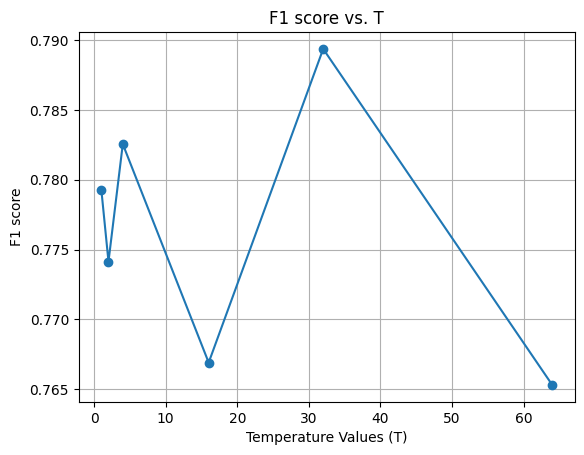

In [ ]:
import matplotlib.pyplot as plt
plt.plot(T_vals, test_F1, '-o')
plt.xlabel('Temperature Values (T)')
plt.ylabel('F1 score')
plt.title('F1 score vs. T')
plt.grid()

# Train student from scratch (NO KD or Tranfer Learning)

In [ ]:
## Student Model (NO KD or TL)
# load trained base model
mobilenet_base = tf.keras.applications.MobileNetV2(include_top=False,
    input_shape=IMG_SHAPE, weights=None)

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = mobilenet_base(x, training = True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
logits = tf.keras.layers.Dense(NUM_CLASSES)(x)

# Build model with inputs and outputs
student_model_scratch = tf.keras.Model(inputs, logits)


#@test {"output": "ignore"}

def compute_scratch_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = student_model_scratch(images, training=True)
  cross_entropy_loss =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits( \
          labels, student_subclass_logits))

  return cross_entropy_loss

tot_epochs = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
f1_hist, acc_hist = train_and_evaluate(student_model_scratch, compute_scratch_cross_entropy_loss, 1e-3, tot_epochs)

print('Average F1 score and class accuracy for the last five epochs')
print('F1 score = ' + str(np.mean(f1_hist[-5:])))
print('class accuracy = ' + str(np.mean(acc_hist[-5:])))

Epoch 1: F1 score: 0.20 - Class accuracy: 64.18%
Epoch 2: F1 score: 0.00 - Class accuracy: 63.15%
Epoch 3: F1 score: 0.00 - Class accuracy: 63.15%
Epoch 4: F1 score: 0.42 - Class accuracy: 69.19%
Epoch 5: F1 score: 0.35 - Class accuracy: 66.02%
Epoch 6: F1 score: 0.30 - Class accuracy: 64.99%
Epoch 7: F1 score: 0.36 - Class accuracy: 65.40%
Epoch 8: F1 score: 0.43 - Class accuracy: 66.73%
Epoch 9: F1 score: 0.38 - Class accuracy: 64.18%
Epoch 10: F1 score: 0.47 - Class accuracy: 69.81%
Epoch 11: F1 score: 0.50 - Class accuracy: 70.21%
Epoch 12: F1 score: 0.50 - Class accuracy: 67.76%
Epoch 13: F1 score: 0.51 - Class accuracy: 69.91%
Epoch 14: F1 score: 0.52 - Class accuracy: 69.60%
Epoch 15: F1 score: 0.50 - Class accuracy: 70.52%
Epoch 16: F1 score: 0.56 - Class accuracy: 73.59%
Epoch 17: F1 score: 0.53 - Class accuracy: 72.26%
Epoch 18: F1 score: 0.60 - Class accuracy: 74.92%
Epoch 19: F1 score: 0.59 - Class accuracy: 74.41%
Epoch 20: F1 score: 0.56 - Class accuracy: 73.49%
Epoch 21:

In [ ]:
## Student Model (NO KD)
# load trained base model
mobilenet_base = tf.keras.applications.MobileNetV2(include_top=False,
    input_shape=IMG_SHAPE, weights="imagenet")
mobilenet_base.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = mobilenet_base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
logits = tf.keras.layers.Dense(NUM_CLASSES)(x)

# Build model with inputs and outputs
student_model_noKD = tf.keras.Model(inputs, logits)

#@test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = student_model_noKD(images, training=True)
  cross_entropy_loss =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits( \
          labels, student_subclass_logits))

  return cross_entropy_loss

## Train model from scratch
# Initial training for the student model
print('INITIAL Training for Student Model (NO KD)')
f1_hist, acc_hist = train_and_evaluate(student_model_noKD, compute_plain_cross_entropy_loss, 1e-3, INITIAL_EPOCHS)

## Fine Tuning Step (make all layers trainable)
mobilenet_base.trainable = True
# Fine tune only top layers
fine_tune_at = 80
for layer in mobilenet_base.layers[:fine_tune_at]:
  layer.trainable = False
print('FINE TUNING Training for Student Model (NO KD)')
f1_hist, acc_hist = train_and_evaluate(student_model_noKD, compute_plain_cross_entropy_loss, 0.1*1e-3, FINE_TUNE_EPOCHS)

print('Average F1 score and class accuracy for the last five epochs')
print('F1 score = ' + str(np.mean(f1_hist[-5:])))
print('class accuracy = ' + str(np.mean(acc_hist[-5:])))

INITIAL Training for Student Model (NO KD)
Epoch 1: F1 score: 0.50 - Class accuracy: 73.80%
Epoch 2: F1 score: 0.57 - Class accuracy: 74.82%
Epoch 3: F1 score: 0.33 - Class accuracy: 69.81%
Epoch 4: F1 score: 0.48 - Class accuracy: 73.08%
Epoch 5: F1 score: 0.57 - Class accuracy: 75.74%
Epoch 6: F1 score: 0.71 - Class accuracy: 79.53%
Epoch 7: F1 score: 0.52 - Class accuracy: 74.41%
Epoch 8: F1 score: 0.65 - Class accuracy: 76.77%
Epoch 9: F1 score: 0.72 - Class accuracy: 77.69%
Epoch 10: F1 score: 0.56 - Class accuracy: 74.72%
FINE TUNING Training for Student Model (NO KD)
Epoch 1: 

F1 score: 0.64 - Class accuracy: 77.58%
Epoch 2: F1 score: 0.71 - Class accuracy: 72.16%
Epoch 3: F1 score: 0.49 - Class accuracy: 74.00%
Epoch 4: F1 score: 0.76 - Class accuracy: 82.29%
Epoch 5: F1 score: 0.78 - Class accuracy: 82.29%
Epoch 6: F1 score: 0.77 - Class accuracy: 83.11%
Epoch 7: F1 score: 0.76 - Class accuracy: 83.42%
Epoch 8: F1 score: 0.78 - Class accuracy: 85.36%
Epoch 9: F1 score: 0.77 - Class accuracy: 80.14%
Epoch 10: F1 score: 0.81 - Class accuracy: 86.18%
Epoch 11: F1 score: 0.79 - Class accuracy: 84.03%
Epoch 12: F1 score: 0.77 - Class accuracy: 79.94%
Epoch 13: F1 score: 0.81 - Class accuracy: 83.93%
Epoch 14: F1 score: 0.73 - Class accuracy: 82.91%
Epoch 15: F1 score: 0.77 - Class accuracy: 79.43%
Epoch 16: F1 score: 0.79 - Class accuracy: 85.06%
Epoch 17: F1 score: 0.81 - Class accuracy: 84.24%
Epoch 18: F1 score: 0.80 - Class accuracy: 82.80%
Epoch 19: F1 score: 0.73 - Class accuracy: 83.11%
Epoch 20: F1 score: 0.80 - Class accuracy: 84.54%
Epoch 21: F1 score

In [ ]:
student_model_noKD.save('/content/drive/My Drive/Colab Notebooks/student_model_noKD_trained.h5')

# Comparing the teacher and student model (number of of parameters and FLOPs)

In [ ]:
# your code start from here for step 8
## https://github.com/tensorflow/tensorflow/issues/32809#issuecomment-849439287
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder
#print('TensorFlow:', tf.__version__)
def get_flops_number(model):
  forward_pass = tf.function(model.call,
      input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])

  graph_info = profile(forward_pass.get_concrete_function().graph,
                        options=ProfileOptionBuilder.float_operation())

  # The //2 is necessary since `profile` counts multiply and accumulate
  # as two flops, here we report the total number of multiply accumulate ops
  flops = graph_info.total_float_ops // 2
  return flops

In [ ]:
# your code start from here for step 8
print('######### Teacher Model, Number of Parameters, Flops ################')
teacher_model.summary()
teacher_flops = get_flops_number(teacher_model)
print('Teacher Flops: {:,}'.format(teacher_flops))

print('######### Teacher Model, Number of Parameters, Flops ################')
student_model.summary()
student_flops = get_flops_number(student_model)
print('Students Flops: {:,}'.format(student_flops))

# Implementing the state-of-the-art KD algorithm

In [ ]:
# your code start from here for step 12
# Please refer to file Task2_tfds_p12.ipynb for implementation

# XAI method to explain models

In [ ]:
# your code start from here for step 13
